In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

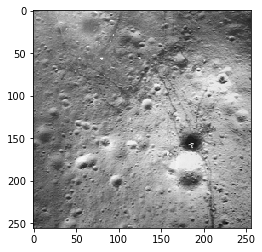

In [60]:
# Read reference image
ref = cv2.imread('luna1.png',0)
plt.imshow(ref,cmap="gray")

In [34]:
# Warp Function
def Warp_4dof(Img,dx,dy,theta,scale):
    rows,cols = Img.shape
    cs = scale * math.cos(theta)
    sn = scale * math.sin(theta)
    
    Rot = np.float32([[cs, sn, 0],[-sn, cs,0],[0,0,1]])
    center_Trans = np.float32([[1,0,cols/2.0],[0,1,rows/2.0],[0,0,1]])
    center_iTrans = np.float32([[1,0,-cols/2.0],[0,1,-rows/2.0],[0,0,1]])
    cRot = np.dot(np.dot(center_Trans,Rot),center_iTrans)
    Trans = np.float32([[1,0,dx],[0,1,dy],[0,0,1]])
    Affine = np.dot(cRot,Trans)
    
    outImg = cv2.warpPerspective(Img,Affine,(cols,rows), cv2.INTER_LINEAR)
    return outImg

Wall time: 3 ms


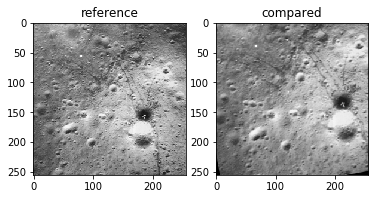

In [61]:
# reference parameter
rdx = 10
rdy = -10
rtheta = 10/180*math.pi
rscale = 1.2
%time compared = Warp_4dof(ref,rdx,rdy,rtheta,rscale)

plt.subplot(1,2,1)
plt.imshow(ref,cmap='gray')
plt.title('reference')
plt.subplot(1,2,2)
plt.imshow(compared,cmap="gray")
plt.title('compared')

In [48]:
# Faster and Lighter Phase Correlation Function
# For only Translation
def CenterOfGravity(mat):
    hei,wid = mat.shape
    Tile=np.arange(wid,dtype=float)-(wid-1.0)/2.0
    Tx = np.tile(Tile,[hei,1]) # Ty = Tx.T
    Sum = np.sum(mat)
    #print(mat)
    Ax = np.sum(mat*Tx)/Sum
    Ay = np.sum(mat*Tx.T)/Sum
    return [Ay,Ax]
def WeightedCOG(mat):
    peak = mat.max()
    newmat = mat*(mat>peak/10)
    Res = CenterOfGravity(newmat)
    return Res
def PhaseCorrelation(a, b):
    height,width = a.shape
    dt = a.dtype # data type
    # Windowing
    hann_ = cv2.createHanningWindow((height, width),cv2.CV_64F)
    hann = hann_.astype(dt) # convert to correspoinding dtype
    # FFT
    G_a = np.fft.fft2(a*hann)
    G_b = np.fft.fft2(b*hann)
    conj_b = np.ma.conjugate(G_b)
    R = G_a*conj_b
    R /= np.absolute(R)
    r = np.fft.fftshift(np.fft.ifft2(R).real)
    # Get result and Interpolation
    DY,DX = np.unravel_index(r.argmax(), r.shape)
    # Subpixel Accuracy
    boxsize = 5
    box = r[DY-int((boxsize-1)/2):DY+int((boxsize-1)/2)+1,DX-int((boxsize-1)/2):DX+int((boxsize-1)/2)+1] # x times x box
    #TY,TX= CenterOfGravity(box)
    TY,TX= WeightedCOG(box)
    sDY = TY+DY
    sDX = TX+DX
    # Show the result
    if 0:
        print('DX=',width/2-sDX,'DY=',height/2-sDY)
        print('CorrelationVal=',r[DY,DX])
        plt.imshow(r,vmin=r.min(), vmax=r.max())
    return [width/2-sDX,height/2-sDY],r[DY,DX]

In [63]:
# Phase Correlation to Estimate Pose

def POC(a,b):
    imshowflag = 1 # show the processing image
    height,width = a.shape
    hann = cv2.createHanningWindow((height, width),cv2.CV_64F);
    rhann = np.sqrt(hann)
    # Windowing and FFT
    G_a = np.fft.fft2(a*rhann)
    G_b = np.fft.fft2(b*rhann)
    # 1. Get Rotation and Scaling Error
    LA = np.fft.fftshift(np.log(np.absolute(G_a)+1))
    LB = np.fft.fftshift(np.log(np.absolute(G_b)+1))
    # 1.1 Log polar
    cx = width / 2
    cy = height / 2
    Mag = width/math.log(width)
    LPA = cv2.logPolar(LA, (cy, cx), Mag, cv2.INTER_LINEAR)
    LPB = cv2.logPolar(LB, (cy, cx), Mag, cv2.INTER_LINEAR)
    # 1.2 Filtering
    lpmin_tuning = 1/2.0 # tuning parameter
    LPmin = math.floor(Mag*math.log(lpmin_tuning*width/2.0/math.pi))
    LPmax = math.floor(Mag*math.log(width/2))-20
    Tile = np.repeat([0.0,1.0,0.0],[LPmin-1,LPmax-LPmin+1,width-LPmax])
    Mask = np.tile(Tile,[height,1])
    LPA_filt = LPA*Mask
    LPB_filt = LPB*Mask
    # 1-3: Phase Correlate to Get Rotation and Scaling
    # Diff,peak = cv2.phaseCorrelate(LPA_filt,LPB_filt)
    Diff,peak = PhaseCorrelation(LPA_filt,LPB_filt)
    #print('DXDY',Diff,'peak',peak)
    theta1 = 360 * Diff[1] / height; # deg
    theta2 = theta1 + 180; # deg
    invscale = math.pow(float(width),Diff[0]/float(width))
    #print('Theta? ',-theta1,'Scale ',1/invscale)
    b1 = Warp_4dof(b,0,0,theta1*math.pi/180,invscale)
    b2 = Warp_4dof(b,0,0,theta2*math.pi/180,invscale)
    diff1, peak1 = PhaseCorrelation(a,b1)
    diff2, peak2 = PhaseCorrelation(a,b2)
    #cv2.phaseCorrelate(a,b1)
    if peak1 > peak2:
        Trans = diff1
        peak = peak1
        theta = -theta1
    else:
        Trans = diff2
        peak = peak2
        theta = -theta2
        
    # Imshow
    if 0:
        plt.subplot(5,2,1)
        plt.imshow(LA,vmin=LA.min(), vmax=LA.max())
        plt.subplot(5,2,2)
        plt.imshow(LB,vmin=LB.min(), vmax=LB.max())
        plt.subplot(5,2,3)
        plt.imshow(LPA,vmin=LPA.min(), vmax=LPA.max())
        plt.subplot(5,2,4)
        plt.imshow(LPB, vmin=LPB.min(), vmax=LPB.max())
        plt.subplot(5,2,5)
        plt.imshow(LPA_filt,vmin=LPA_filt.min(), vmax=LPA_filt.max())
        plt.subplot(5,2,6)
        plt.imshow(LPB_filt, vmin=LPB_filt.min(), vmax=LPB_filt.max())
        plt.subplot(5,2,7)
        plt.imshow(b1,vmin=b1.min(), vmax=b1.max())
        plt.subplot(5,2,8)
        plt.imshow(b2, vmin=b2.min(), vmax=b2.max())

    return [Trans[0],Trans[1],theta,1/invscale]

In [66]:
# Test 
ref = np.float64(ref)
compared = np.float64(compared)
%timeit POC(ref,compared)

10 loops, best of 3: 67.6 ms per loop


memo

Manuel Guizar-Sicairos, Samuel T. Thurman, and James R. Fienup, “Efficient subpixel image registration algorithms,” Optics Letters 33, 156-158 (2008). DOI:10.1364/OL.33.000156

In [57]:
%timeit fuga = cv2.phaseCorrelate(ref,compared,rhann)

100 loops, best of 3: 2.88 ms per loop


In [55]:
# OpenCV Phase correlation function
hann = cv2.createHanningWindow((256, 256),cv2.CV_64F);
rhann = np.sqrt(hann)
dx,dy = cv2.phaseCorrelate(ref,compared,rhann)
print(dx,dy)

(-27.658386211792305, 6.032979665299834) 0.030519718385156276


In [58]:
%timeit fuga =  PhaseCorrelation(ref,compared)

100 loops, best of 3: 19.8 ms per loop


[[-0.06091055 -0.06433463  0.01845918]
 [ 0.54651827  0.57173421 -0.18188716]
 [ 0.06356026  0.06346476 -0.02173205]]


-0.021732047123322912

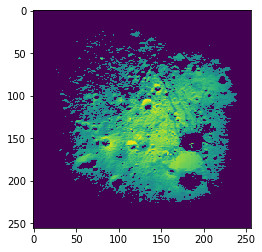

In [192]:
refcpy = ref
#np.where(refcpy>100)
plt.imshow(refcpy*(refcpy>100))

In [ ]:
    G_b1r = Warp_4dof(np.real(G_b).astype(float),0,0,theta1*math.pi/180,invscale)
    G_b1i = Warp_4dof(np.imag(G_b).astype(float),0,0,theta1*math.pi/180,invscale)
    G_b2r = Warp_4dof(np.real(G_b).astype(float),0,0,theta2*math.pi/180,invscale)
    G_b2i = Warp_4dof(np.imag(G_b).astype(float),0,0,theta2*math.pi/180,invscale)
    G_b1 = np.array(G_b1r, dtype=complex)
    G_b1 = G_b1 + 1.0j*G_b1i
    G_b2 = np.array(G_b2r, dtype=complex)
    G_b2 = G_b2 + 1.0j*G_b2i

    conj_b1 = np.ma.conjugate(G_b1)
    R1 = G_a*conj_b1
    R1 /= np.absolute(R1)
    r1 = np.fft.fftshift(np.fft.ifft2(R1).real)
    # Get result and Interpolation
    DY1,DX1 = np.unravel_index(r1.argmax(), r1.shape)
    # Subpixel Accuracy
    boxsize = 5
    box1 = r1[DY1-int((boxsize-1)/2):DY1+int((boxsize-1)/2)+1,DX1-int((boxsize-1)/2):DX1+int((boxsize-1)/2)+1] # x times x box
    #TY,TX= CenterOfGravity(box)
    TY1,TX1= WeightedCOG(box1)
    sDY1 = TY1+DY1
    sDX1 = TX1+DX1
    # Show the result
    print('DX=',width/2-sDX1,'DY=',height/2-sDY1)
    print('CorrelationVal=',r1[DY1,DX1])

    conj_b2 = np.ma.conjugate(G_b2)
    R2 = G_a*conj_b2
    R2 /= np.absolute(R2)
    r2 = np.fft.fftshift(np.fft.ifft2(R2).real)
    # Get result and Interpolation
    DY2,DX2 = np.unravel_index(r2.argmax(), r2.shape)
    # Subpixel Accuracy
    boxsize = 5
    box2 = r2[DY2-int((boxsize-1)/2):DY2+int((boxsize-1)/2)+1,DX2-int((boxsize-1)/2):DX2+int((boxsize-1)/2)+1] # x times x box
    #TY,TX= CenterOfGravity(box)
    TY2,TX2= WeightedCOG(box2)
    sDY2 = TY2+DY2
    sDX2 = TX2+DX2
    # Show the result
    print('DX=',width/2-sDX2,'DY=',height/2-sDY2)
    print('CorrelationVal=',r2[DY2,DX2])
